In [222]:
# Lets go back over the weather classification task with PyTorch
# I'll be creating a new virtual env "wx_class_env" for this using Python 3.10

# Also, this will be done in a Docker container instead... 

In [223]:
"""
Develop a CNN that accomplishes the following tasks:
    1) Classifies different weather phenomena of at least 4 different classes
    2) Achieves an accuracy of at least 80% (high precision)
    3) Makes use of pre-created architectures like ResNet, AlexNet, VGG, and any others
    4) Create a model from scratch as well
""";

In [224]:
# Torch check
import torch

print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Type: {torch.cuda.get_device_name(0)}")

CUDA Available: True
CUDA Type: NVIDIA GeForce GTX 1660 SUPER


### Data Collection

In [225]:
# Packages
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import random

In [226]:
# Start by accessing the data and opening some images
img_pth = "C:/Users/colts/OneDrive/Desktop/Python_Projects/Neural_Networks/Computer Vision/" \
    "ImageClassification/Image_Data/WeatherImages" 

img_folders = os.listdir(img_pth)

# Define image type
ext = ['jpg', 'jpeg']

# Show image types in folders - Should have a wide variety to choose from
print(img_folders)
print(f"Total unique weather types available: {len(img_folders)}")

['cloudy', 'dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Total unique weather types available: 12


In [227]:
# Collect images and their respective labels
def CollectImages(PATH, folder, image_ext, dspl_cnt=0):
    images = []
    for ext in image_ext:
        for file in glob.glob(PATH + "/" + folder + '/*.' + ext):
            # Using Pillow to reshape and convert the images
            images.append(file)

    if dspl_cnt == 1:
        # Displays number of images in each folder
        print(f"Number of Images in folder {folder}: {len(images)}")
    
    # Shuffles for randomness
    np.random.shuffle(images)
    
    # Returns the list of images along with an index of values that changes each run
    return images, np.array([folder for i in range(len(images))])

In [228]:
%%time

# Load in the images
images, added_labels = [], []
images_dict = {}

for file in img_folders:
    # To show the number of images per folder, change the 'dspl_cnt' to a 1
    image, label = CollectImages(img_pth, file, ext, dspl_cnt=1)
    images_dict[file] = label.shape[0]
    images.extend(image)
    added_labels.extend(label)

# Building series for the dataframe 
image_paths = pd.Series(images, name='Images').astype(str)
labels_for_image = pd.Series(added_labels, name='Class')

# Building dataframe
img_df = pd.concat([image_paths, labels_for_image], axis=1)
img_df = img_df.sample(frac=1).reset_index(drop=True)

Number of Images in folder cloudy: 310
Number of Images in folder dew: 698
Number of Images in folder fogsmog: 851
Number of Images in folder frost: 475
Number of Images in folder glaze: 639
Number of Images in folder hail: 591
Number of Images in folder lightning: 377
Number of Images in folder rain: 526
Number of Images in folder rainbow: 232
Number of Images in folder rime: 1160
Number of Images in folder sandstorm: 692
Number of Images in folder snow: 621
CPU times: total: 15.6 ms
Wall time: 56.6 ms


In [229]:
# Sample of the dataframe
img_df.sample(5)

,Images,Class
2816,C:/Users/colts/OneDrive/Desktop/Python_Project...,hail
2420,C:/Users/colts/OneDrive/Desktop/Python_Project...,rainbow
4930,C:/Users/colts/OneDrive/Desktop/Python_Project...,rime
3348,C:/Users/colts/OneDrive/Desktop/Python_Project...,dew
5367,C:/Users/colts/OneDrive/Desktop/Python_Project...,frost


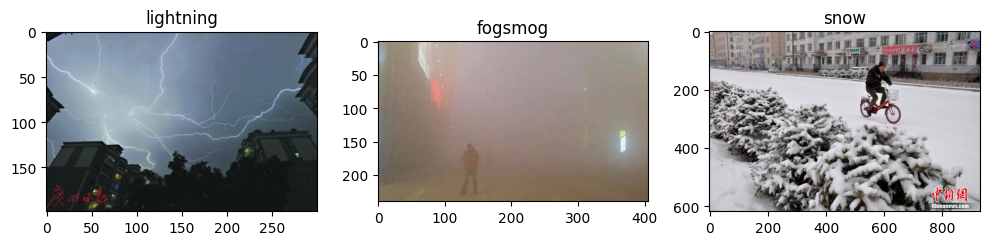

In [230]:
# Randomly select a set of 3 images to display from some folders - can add to a df

rand_int_1, rand_int_2, rand_int_3 = \
    random.randint(0, len(img_df)), random.randint(0, len(img_df)), random.randint(0, len(img_df))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
ax[0].imshow(plt.imread(img_df["Images"][rand_int_1]))
ax[0].set_title(img_df["Class"][rand_int_1])

ax[1].imshow(plt.imread(img_df["Images"][rand_int_2]))
ax[1].set_title(img_df["Class"][rand_int_2])

ax[2].imshow(plt.imread(img_df["Images"][rand_int_3]))
ax[2].set_title(img_df["Class"][rand_int_3])
plt.tight_layout()
plt.show()

### Data Exploration

In [231]:
# Basic EDA to get a sense of what we're looking at...
"""
What goes into our EDA?:
    1) Get a sense of the number of images we're working with
    2) It would be great to get the size of the largest & smallest images in the dataset
    3) How's the data spread? Are some folders larger than others?
""";

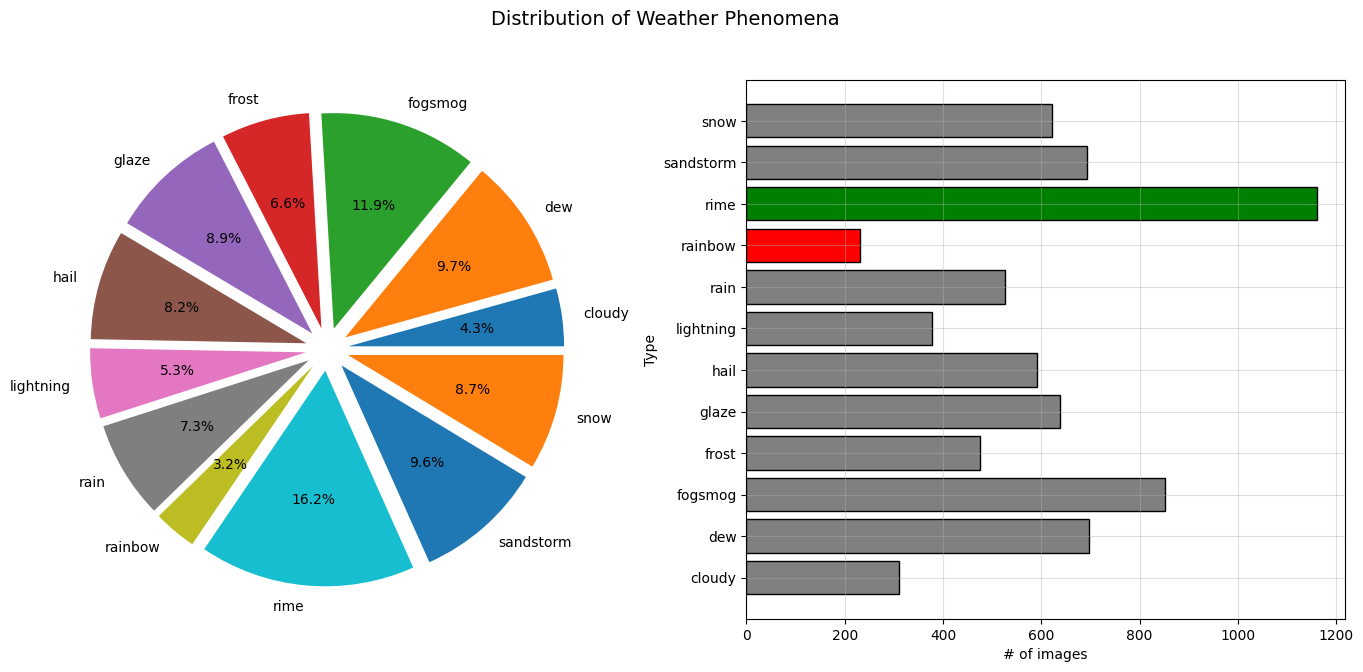

In [232]:
# Look at the number of images per folder - use df

# Build a visual, pie chart works since we want to see the whole also
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

###############################################################################

# Calculates the percent of the whole
def percent(x):
    val = round(x, 1)
    return f"{val}%"

explode_piece = [0.1] * len(img_folders)
ax[0].pie(images_dict.values(), labels=images_dict.keys(), textprops=dict(color="black"), 
        explode=explode_piece, autopct=lambda x: percent(x));

###############################################################################

img_dict_lst = list(images_dict.values())

# Color the max & min values accoridingly
max_val = img_dict_lst.index(max(img_dict_lst))
min_val = img_dict_lst.index(min(img_dict_lst))

colors = ['gray' if i != max_val and i != min_val else ('green' if i == max_val else 'red') 
            for i in range(len(img_dict_lst))]

# Creates a horizontal bar chart
ax[1].barh(list(images_dict.keys()), list(images_dict.values()), edgecolor="black", color=colors)
ax[1].grid(alpha=0.4)
ax[1].set_ylabel("Type")
ax[1].set_xlabel("# of images")

###############################################################################

plt.suptitle("Distribution of Weather Phenomena", color="black", size=14);
plt.show()

In [233]:
# Function for extracting image dimensions
def dimensions(pth):
    img = Image.open(pth)
    h, w = img.size

    # Total pixels
    tot = w * h

    # Return the dimensions
    return h, w, tot

In [234]:
from PIL import Image

# Find the largest and smallest images in the dataset
img_df["dimensions"] = img_df["Images"].apply(lambda pth: dimensions(pth))
img_df[["width", "height", "pixel_total"]] = img_df["dimensions"].apply(pd.Series)
img_df["len_of_dimension"] = img_df["dimensions"].apply(lambda x: len(x))

In [235]:
# Drop the 'dimensions" column
img_df = img_df.drop(["dimensions"], axis=1)

In [236]:
img_df['len_of_dimension'].unique()

array([3], dtype=int64)

In [237]:
# We can sort by a variety of dimension attributes now
img_df = img_df.sort_values(by=["pixel_total"], ascending=False).reset_index(drop=True)

In [238]:
# Why are dimensions important? Since we'll need to do some re-sizing to make all images fit the same, we'll want to 
# get an ideas as to which categories will be the most impacted

# As I initally mentioned, I'll only be picking a handful of image classes to start, I'll randomly select ~250
# or so images from each folder to use in the model. 
# This is done to help battle data imbalance.

In [239]:
# Final component is shrinking the dataset to incorporate my requirements for the model
# Create a copy
img_df_modeling = img_df.copy()

In [240]:
# I want to incorporate at least 250 images of each class, for at least 4 classes
img_df_modeling = img_df_modeling.sort_values(by=["Class"]).reset_index(drop=True)

# I will also drop all 'rainbow' values as that class contains the least amount of images by a 
# sizable margin...
img_df_modeling = img_df_modeling[img_df_modeling["Class"] != "rainbow"]

In [241]:
# Trimming the classes down to 6 - Start with 6 key meteorological phenomena
img_shrunk = img_df_modeling[(img_df_modeling["Class"] == "cloudy") | (img_df_modeling["Class"] == "rain") 
    | (img_df_modeling["Class"] == "lightning") | (img_df_modeling["Class"] == "frost") | (img_df_modeling["Class"] == "hail") 
    | (img_df_modeling["Class"] == "snow")].reset_index(drop=True);

# This updates as we introduce (or remove) classes...
img_modeling_lst = list(img_shrunk.groupby(["Class"]).count()["Images"])

In [242]:
# Using pandas functionality here to create another df...
smpl = min(img_modeling_lst)
imgs = img_shrunk.groupby(["Class"]).apply(lambda x: x.sample(smpl, replace=False)).reset_index(drop=True)

# Now we have a slimmer dataset with evenly split data for training. This also gives the the option to add more images
# to classes and the dataframe will always update to the least populated class

# I'll be trimming this down by going down to 6 classes for now rather than 11.

C:\Users\colts\AppData\Local\Temp\ipykernel_35152\3906291126.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  imgs = img_shrunk.groupby(["Class"]).apply(lambda x: x.sample(smpl, replace=False)).reset_index(drop=True)


In [243]:
# Showcase count per class
imgs.groupby(["Class"]).count()

,Images,width,height,pixel_total,len_of_dimension
Class,,,,,
cloudy,310,310,310,310,310
frost,310,310,310,310,310
hail,310,310,310,310,310
lightning,310,310,310,310,310
rain,310,310,310,310,310
snow,310,310,310,310,310


In [244]:
# Sample the data
imgs["Images"].iloc[274]

'C:/Users/colts/OneDrive/Desktop/Python_Projects/Neural_Networks/Computer Vision/ImageClassification/Image_Data/WeatherImages/cloudy\\cloudy55.jpg'

In [245]:
# Unhash this to use as an image checker...
"""
x = random.randint(0, len(imgs))

plt.figure(figsize=(10,5))
plt.imshow(plt.imread(imgs["Images"].iloc[x]))
""";

### Building the Dataset

In [246]:
# Converting the raw images to a PyTorch-acceptable dataset...
# Big question is, what do we need to do here?
"""
What goes into our PyTorch Dataset?:
    1) We need to convert the images from being raw into arrays, so the computer can read it
    2) We'll need to isolate the classes, thankfully the dirty work is done thanks to
       the dataframe
    3) Convert our arrays to tensors, this is just a matter of re-arranging the location of some
       of the tuple values for each size (H x W x C) -> (C x H x W); Tensors have the color field
       first unlike arrays, that's the key difference
""";

In [247]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torchvision.io import read_image

from skimage import io, transform
from sklearn.preprocessing import LabelEncoder

In [248]:
# Lets convert the classes to numbers using LabelEncoder
label = LabelEncoder()
imgs["Class_Tokenized"] = label.fit_transform(imgs["Class"])

# Also I'll build a matching dict to connect each item to its label
cls, cls_tkn = imgs["Class"].unique(), imgs["Class_Tokenized"].unique()
label_dict = {}

# Loop through
for i in range(0, len(cls)):
    label_dict[cls_tkn[i]] = cls[i]

In [249]:
# Create a PyTorch dataset class
class weatherImageDataset(Dataset):
    def __init__(self, model_df, transform=None, target_transform=None):
        self.model_df = model_df
        self.transform = transform

    def __len__(self):
        return len(self.model_df)

    def __getitem__(self, idx):

        # Dataframe, access the column of images
        img_path = self.model_df["Images"].iloc[idx]

        # Convert images to RGB, some are in grey scale (using Pillow to do this instead)
        img_original = Image.open(img_path)
        rgb = img_original.convert("RGB")

        # Converting the image to a numpy array
        image = np.array(rgb)

        # Same for the label as above
        label = np.array(self.model_df["Class_Tokenized"].iloc[idx])

        # I have this being returned as two seperate items, could have it be a dict too?
        sample = {"image": image, "event": label}

        # Transformations
        if self.transform:
            sample = self.transform(sample)

        return sample

In [250]:
# Test the image collection class
rand_img = random.randint(0, weatherImageDataset(imgs).__len__()-1)

# Add 'transform' and 'target_transform' attributes here
testWX = weatherImageDataset(imgs) 
# testWX[rand_img]

# Testing image calls
for x in range(0, 4):
    rand_x = random.randint(0, weatherImageDataset(imgs).__len__()-1)
    print(testWX[rand_x]["image"].shape, testWX[rand_x]["event"])

(266, 400, 3) 5
(349, 530, 3) 5
(240, 320, 3) 4
(240, 414, 3) 4


In [261]:
# Transformations & Rescaling
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample["image"], sample["event"]

        # Pulling out shapes
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        # Unhash to see original image sizes
        # print(f"Original: h: {h} w: {w}")
        new_h, new_w = int(new_h), int(new_w)

        # Fully resize image
        img = transform.resize(image, (new_h, new_w))

        return {"image": img, "event": label}

# Applies a random crop to the image (Data Augmentation)
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['event']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        # Get random locations to crop the image
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        # Apply those locations to the image, creating a "new" image
        img = image[top: top + new_h,
                      left: left + new_w]

        return {"image": img, "event": label}

# Converts the image to a tensor
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample["image"], sample["event"]

        # Arrays and Tensors are nearly identical, just the color channel is in a different spot
        image = image.transpose((2, 0, 1))
        
        # Only return image for normalization
        # return torch.from_numpy(np.float32(image))
        return {"image": torch.from_numpy(np.float32(image)), "event": label}

# Define a normalization class
class Normalize(object):
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)

    def __call__(self, sample):
        image, label = sample['image'], sample['event']
        image = self.normalize(image)
        return {'image': image, 'event': label}

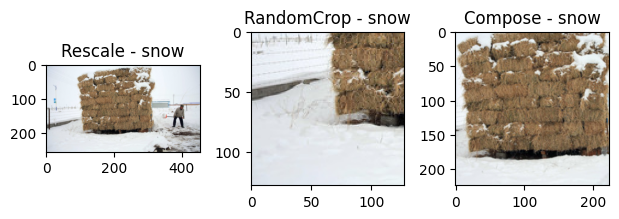

In [262]:
# Transformations
rescale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# Rand int
rand_x = random.randint(0, weatherImageDataset(imgs).__len__()-1)

# Test the Rescale - Use a tuple to make images semmetrical, a single int to keep aspect ratio
testWX_v2 = weatherImageDataset(imgs)

# Apply each of the above transforms on a sample
fig = plt.figure()
sample = testWX_v2[rand_x]
for i, tsfrm in enumerate([rescale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    plt.imshow(transformed_sample["image"])
    ax.set_title(f"{type(tsfrm).__name__} - {label_dict[int(transformed_sample['event'])]}")

plt.show()

### Priming the Dataloader

In [263]:
# Create a dataloader for the dataset
testWX_modeling = weatherImageDataset(imgs,
                            transform=transforms.Compose([
                                    Rescale(256),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=[0.485, 0.456, 0.406], 
                                                  std=[0.229, 0.224, 0.225])
                                ]))

In [270]:
# Test tensors
testWX_modeling[2]

{'image': tensor([[[-0.9638, -0.9294, -0.8920,  ..., -0.4442, -0.4556, -0.4670],
          [-0.9298, -0.8902, -0.8509,  ..., -0.4589, -0.4728, -0.4896],
          [-0.9030, -0.8592, -0.8182,  ..., -0.4789, -0.4941, -0.5168],
          ...,
          [-2.0317, -2.0423, -2.0527,  ..., -1.8476, -1.8536, -1.8536],
          [-2.0717, -2.0730, -2.0708,  ..., -1.8604, -1.8662, -1.8688],
          [-2.1012, -2.0916, -2.0814,  ..., -1.8757, -1.8812, -1.8913]],
 
         [[-0.8558, -0.8207, -0.7824,  ..., -0.3247, -0.3363, -0.3480],
          [-0.8210, -0.7806, -0.7404,  ..., -0.3397, -0.3539, -0.3711],
          [-0.7937, -0.7489, -0.7070,  ..., -0.3602, -0.3756, -0.3989],
          ...,
          [-1.9476, -1.9584, -1.9690,  ..., -1.7594, -1.7655, -1.7655],
          [-1.9884, -1.9898, -1.9875,  ..., -1.7724, -1.7784, -1.7811],
          [-2.0186, -2.0088, -1.9984,  ..., -1.7881, -1.7937, -1.8041]],
 
         [[-0.6298, -0.5948, -0.5567,  ..., -0.1010, -0.1126, -0.1242],
          [-0.5952,

In [266]:
# Loop through some test images
for i, sample in enumerate(testWX_modeling):
    print(i, sample['image'].size(), sample['event'])
    if i == 3:
        break

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


In [267]:
# Need to split the data into training & validation sets
batch_size = 32
validation_split = .15
shuffle_dataset = True
random_seed= 42

# Collect indicies for splitting
dataset_size = len(testWX_modeling)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

# Shuffle the dataset
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

# Store the indicies
train_indices, val_indices = indices[split:], indices[:split]

In [268]:
# Define the dataloaders - wrapping and iterable around the dataset
val_batch = (len(train_indices)//len(val_indices))

train_loader = DataLoader(dataset=testWX_modeling, batch_size=batch_size, 
                            num_workers=0, sampler=train_indices)

# I want a ratio batch for validation to pair with the training
val_loader = DataLoader(dataset=testWX_modeling, batch_size=val_batch, 
                            num_workers=0, sampler=val_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([32, 3, 224, 224]) torch.Size([32])
tensor([4, 5, 3, 4, 1, 4, 0, 3, 4, 1, 3, 5, 1, 3, 0, 5, 1, 5, 4, 0, 4, 0, 4, 2,
        3, 1, 4, 1, 1, 5, 1, 2], dtype=torch.int32)


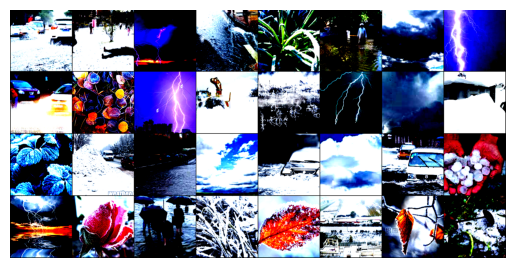

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([5, 3, 224, 224]) torch.Size([5])
tensor([0, 1, 4, 4, 1], dtype=torch.int32)


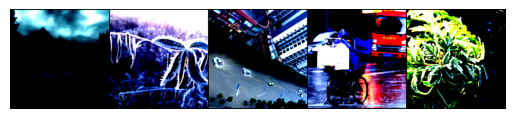

In [269]:
"""
Reference:
    * dataset: The dataset being used
    * batch_size: How many images will be in each batch that's passed into the model
    * shuffle: Shuffles images in the dataset for different batches each time
    * num_workers: Number of subprocesses used when loading the data
"""

# Helper function to show a batch
def wx_image_batch(batch):
    images_batch = batch['image']

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, batch in enumerate(train_loader):
    print(i_batch, batch['image'].size(), batch['event'].size())
    print(batch["event"])
    # observe 1 batch with the images & labels
    if i_batch == 0:
        plt.figure()
        wx_image_batch(batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

for i_batch, batch in enumerate(val_loader):
    print(i_batch, batch['image'].size(), batch['event'].size())
    print(batch["event"])
    # observe 1 batch with the images & labels
    if i_batch == 0:
        plt.figure()
        wx_image_batch(batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [271]:
# For reference
label_dict

{0: 'cloudy', 1: 'frost', 2: 'hail', 3: 'lightning', 4: 'rain', 5: 'snow'}

### Building the CNN

In [272]:
# Building out the CNN - Build and export to a Python script for standalone access
# and reference that here

In [273]:
"""
What is the objective with the CNN?:
    1) To create a model that is capable of picking up patterns that occur in each weather phenomena's images
    2) To explore with several types of CNN's, from per-built like ResNet or VGG, as well as building
       my own from scratch
    3) Create an exportable model that can be attached to an application on a website, such as my own
       personal with Django
""";

In [274]:
# Launched here, created in a seperate script
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Import the net from the python script
from madeCNN import Net

# Modeling support packages
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

#### From Scratch

In [275]:
# Instantiate the NN
baseNet = Net()

# Set both the optimizer and the loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseNet.parameters(), lr=0.001, momentum=0.9)

In [276]:
# Check for GPU
if torch.cuda.is_available():
    model = baseNet.cuda()
    print("Model CUDA: READY")

    criterion = criterion.cuda()
    print("Criterion CUDA: READY", '\n')

# Very basic model for now
print(model)

Model CUDA: READY
Criterion CUDA: READY 

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [277]:
"""
Checklist:
    1) Dataset
        - Data is split and cleaned
        - converted to all one channel type (rgb)
    2) Dataloaders
        - Two dataloaders made, Training and Validation
    3) Model Building
        - Base NN is constructed using PyTorch tutorial
        - Optimizer set
        - Loss function set
        - NEED metrics (precision/recall?) - Loss is used for now
        - timing for training (just to keep track of training times)
            * In log files using tensorboard
        - training loop to actually train the model
            * Incorporate validation at the end of each training batch batch
            * Spits out resuts in a log file
""";

In [278]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [279]:
# Train the model & validate each batch
def train(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0.0

    # Looping over the training loader
    for i, data in enumerate(train_loader):  # batch --> 'image' & 'event'
        
        # Every data instance is an input + label pair
        labels = data["event"].type(torch.LongTensor)
        inputs, labels = data["image"].to(device), labels.to(device)
 
        # Zero your gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [280]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/wx_image_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 1

best_vloss = 1000000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train(epoch_number, writer)

    running_vloss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vlabels = vdata["event"].type(torch.LongTensor)
            vinputs, vlabels = vdata["image"].to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS - train: {} | valid: {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    """
    $$$ Unhash if model is meant to be saved $$$
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    """
    epoch_number += 1

EPOCH 1:


c:\Users\colts\OneDrive\Desktop\Python_Projects\Neural_Networks\Computer Vision\Weather_Classification\madeCNN.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))           # Applying softmax on the output


LOSS - train: 0.0 | valid: 1.7898578643798828


#### ResNet50

In [4]:
# Using pre-made ResNet50 model - Download from PyTorch or Code on your own


Using cache found in C:\Users\colts/.cache\torch\hub\pytorch_vision_v0.10.0


#### GoogLeNet (Inception)

In [ ]:
# Using pre-made GoogLeNet model